# CS210 Data Science Project - Rhythms of Code

## Motivation

 
As a Computer Science student, I wanted to learn about my habits. Writing code is more than just an academic activity for me, I like building software in my spare time. Over time, I've noticed that music is almost always a part of this routine. Whether it's a soothing melody or an upbeat tune, music seems to keep me company and possibly, influences my coding efficiency. This got me thinking - does music really make a difference in my productivity? This is where this project comes in, I wanted to figure out if there is a relation between my sleep, music listening and coding habits.

## Data Collection

In [1]:
# Import necessary packages
import requests
from datetime import datetime
import os
from pprint import pprint
import json

# Define helper functions for reading and writing data
def read_data(filename: str):
    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

def write_data(filename: str, data: dict):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

### Collecting daily sleep-wake times

- Obtained this data by writing a script to parse sleep/wake times from my personal diary which I keep using [Obsidian](https://obsidian.md/). 
- The nice part about Obsidian is that each file is just a markdown file, so scraping the necessary part was just a simple script. 
- A sample of the output is shown below.  

```json
{
  "2023-08-19": {'sleep': '00:30:00', 'wake': '09:30:00'},
  "2023-08-20": {'sleep': '23:00:00', 'wake': '10:30:00'}
}
```

In [2]:
# Script to collect data from .md files
def collect_sleep_wake_times():
    sleep_wake_data = {}
    for file_name in os.listdir("personal_data"):
        with open(f"personal_data/{file_name}") as f:
            text = f.read()
        lines = text.split("\n")
        times = {"wake": None, "sleep": None}
        for line in lines:
            if times["sleep"] is not None and times["wake"] is not None:
                break
            if "Wake" in line:
                time = line.split()[1].replace(".", ":") + ":00"
                times["wake"] = time
            elif "Sleep" in line:
                time = line.split()[1].replace(".", ":") + ":00"
                times["sleep"] = time
        sleep_wake_data[file_name.split(".")[0]] = times
    return sleep_wake_data

In [16]:
sleep_wake_data = collect_sleep_wake_times()
pprint(sleep_wake_data["2023-09-28"])

# Store the data in a json file for processing later
write_data("data_sleep_wake.json", sleep_wake_data)

{'sleep': '00:00:00', 'wake': '11:30:00'}


### Collecting Daily Github Commits

- Obtained daily github commit information using the GitHub API.
- Since the Github API has no direct access to commit information past 180 days, had to come up with a work around.
- First got all the repo names using my access token and stored them as a list, then wrote a function to get all the commits for a repository given the repository name.
- Finally, combined these and cleaned up so that the relevant dates were collected.
- A sample output is shown below.

```json
{
  "2023-09-17": [
    {'message': 'Update README.md', 'time': '21:56:03'},
    {'message': 'Handle toasts more gracefully', 'time': '11:44:52'}
  ],
  "2023-09-18": []
}
```

In [17]:
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

token = os.environ.get('GITHUB_TOKEN')
username = os.environ.get('GITHUB_USERNAME')

# Get all repository names including private ones using personal access token
def get_all_repo_names():
    url = f'https://api.github.com/search/repositories?q=user:{username}'
    headers = {'Authorization': f'Bearer {token}'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching repository names, code: {response.status_code}")
        return []
    items = response.json()
    repo_names = [item['name'] for item in items['items']]
    return repo_names

# Get all commits for a repository
def get_commits_for_repo(repo_name: str):
    url = f'https://api.github.com/repos/{username}/{repo_name}/commits?per_page=100'
    headers = {'Accept': "application/vnd.github+json",
               'Authorization': f'Bearer {token}'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching commits, code: {response.status_code}")
        return []
    all_commits = response.json()
    user_commits = [commit for commit in all_commits if commit['commit']['committer']['name'] == username]
    clean_commits = [
        {
            'date': commit['commit']['committer']['date'],
            'message': commit['commit']['message'],
        } for commit in user_commits
    ]
    return clean_commits

# Combine and filter commits by date
def collect_commits_between_dates():
    data = {}
    repo_names = get_all_repo_names()
    print(f"Repository Count: {len(repo_names)}")
    for repo_name in repo_names:
        data[repo_name] = get_commits_for_repo(repo_name)
    all_commits = [commit for repo in data.values() for commit in repo]
    commits_by_date = {}
    for commit in all_commits:
        time = datetime.strptime(commit['date'], '%Y-%m-%dT%H:%M:%SZ')
        if datetime(2023, 8, 19) <= time < datetime(2023, 10, 27):
            date = str(time.date())
            time = str(time.time())
            if date in commits_by_date:
                commits_by_date[date].append({
                    'time': time,
                    'message': commit['message'],
                })
            else:
                commits_by_date[date] = [{
                    'time': time,
                    'message': commit['message'],
                }]
    return commits_by_date

In [18]:
commits_by_dates = collect_commits_between_dates()
pprint(commits_by_dates["2023-09-17"])

# Store the data in a json file for processing later
write_data("data_commits_by_date.json", commits_by_dates)

Repository Count: 18
[{'message': 'Update README.md', 'time': '21:56:03'},
 {'message': 'SEO and a11y', 'time': '21:55:45'},
 {'message': 'Handle toasts more gracefully', 'time': '11:44:52'}]


### Collecting Daily Listening Information

- Obtained this data by navigating to ["Download your Data"](https://www.spotify.com/us/account/privacy/) and selecting "Extended Streaming History" then requesting my data from Spotify.
- After a week of waiting, the data was ready to use. 
- The data was processed and reduced to include relevant dates and songs that were listened to for longer than 10 seconds.
- Sample output data is shown below.

```json
{
  '2023-08-19': [{'name': 'Feint - Snake Eyes',
                 'played': '03:10.00',
                 'time': '11:39:05'}],
  '2023-08-20': [],
  '2023-08-21': [{'name': 'The Luna Sequence - Sanctuary in Dying Light',
                  'played': '04:50.00',
                  'time': '11:00:01'},
                  {'name': 'Fractal Dreamers - Virulence',
                  'played': '02:20.00',
                  'time': '11:50:40'}
                ],
}
```

In [112]:
# 
def collect_listened_between_dates():
    data1 = read_data('spotify_data/2022-2023.json')
    data2 = read_data('spotify_data/2023_2.json')
    data3 = read_data('spotify_data/2023_3.json')
    all_listened = data1 + data2 + data3
    listened_by_date = {}
    for data in all_listened:
        # Get timestamp
        datetime_string = data.get('ts')
        datetime_object = datetime.strptime(datetime_string, '%Y-%m-%dT%H:%M:%SZ')
        # Between 19/08/2023 - 26/10/2023
        if datetime(2023, 8, 19) <= datetime_object < datetime(2023, 10, 27):
            # Accept song only if it has been listened to for at least 10 seconds
            ms = data.get('ms_played')
            if ms < 10 * 1000:
                continue
            date = str(datetime_object.date())
            time = str(datetime_object.time())
            minutes, remainder = divmod(ms // 1000, 60)
            seconds, milliseconds = divmod(remainder, 1)
            played = f"{minutes:02d}:{int(seconds):02d}"
            track_name = f"{data.get('master_metadata_album_artist_name')} - {data.get('master_metadata_track_name')}"
            if date in listened_by_date:
                listened_by_date[date].append({
                    'played': played,
                    'time': time,
                    'name': track_name
                })
            else:
                listened_by_date[date] = [{
                    'played': played,
                    'time': time,
                    'name': track_name,
                }]
    return listened_by_date

[{'name': 'Feint - Vagrant', 'played': '03:17', 'time': '11:39:06'},
 {'name': 'Rob Gasser - Supersonic', 'played': '01:06', 'time': '11:40:12'},
 {'name': 'Culture Code - Slow Burn (feat. Alexa Ayaz) (Original Mix)',
  'played': '01:06',
  'time': '11:58:35'},
 {'name': 'Virtual Riot - Sugar Rush', 'played': '03:48', 'time': '17:09:25'},
 {'name': 'Koven - Telling Me', 'played': '00:46', 'time': '17:10:13'},
 {'name': 'Rob Gasser - Meltdown (Feat. Richard Caddock)',
  'played': '01:43',
  'time': '17:12:07'},
 {'name': 'Stan SB - Flat Foot Face', 'played': '03:48', 'time': '17:16:01'},
 {'name': 'Feint - Fall Away', 'played': '05:10', 'time': '17:21:11'},
 {'name': 'T & Sugah - Demons', 'played': '01:52', 'time': '17:23:05'},
 {'name': 'Paris Blohm - Left Behinds', 'played': '03:00', 'time': '17:26:04'},
 {'name': 'Veela - Circa 1620', 'played': '03:49', 'time': '17:29:54'},
 {'name': 'Echos - Fiction', 'played': '03:09', 'time': '17:33:04'},
 {'name': 'MUZZ - The Phantom', 'played': 

In [ ]:

listened_by_date = collect_listened_between_dates()
pprint(listened_by_date["2023-08-19"])

# Store the data in a json file for processing later
write_data("data_listened_by_date.json", listened_by_date)

## Data Processing

- After the data collecting phase, some data processing was done in order to get the data to a state where it can be used in the hypothesis.
- The data 

In [166]:
from datetime import timedelta
import pandas as pd

data_frame = {}

def get_time_of_day(time: datetime):
  if 6 <= time.hour < 12:
    return "morning"
  elif 12 <= time.hour < 18:
    return "afternoon"
  elif 18 <= time.hour < 24:
    return "evening"
  else: # 0 <= time.hour < 6
    return "night"

sleep_wake_data = read_data("data_sleep_wake.json")

# Process data
for date, times in sleep_wake_data.items():
  # Convert to datetime objects
  wake_time = datetime.strptime(f"{date} {times['wake']}", "%Y-%m-%d %H:%M:%S")
  sleep_time = datetime.strptime(f"{date} {times['sleep']}", "%Y-%m-%d %H:%M:%S")

  # Adjust for the fact that sleep could be on the next day
  if sleep_time <= wake_time:
      sleep_time += timedelta(days=1)

  awake_duration = sleep_time - wake_time
  # Form dataframe shell
  data_frame[date] = {"wake": wake_time, "sleep": sleep_time, "awake_hours": int(awake_duration.total_seconds() / 3600),
                      "total_commit_count": 0, "total_listened_count": 0, "total_listened_seconds": 0,
                      "morning_listened_seconds": 0, "morning_listened_count": 0, "morning_commit_count": 0, 
                      "afternoon_listened_seconds": 0, "afternoon_listened_count": 0, "afternoon_commit_count": 0, 
                      "evening_listened_seconds": 0, "evening_listened_count": 0, "evening_commit_count": 0,
                      "night_listened_seconds": 0, "night_listened_count": 0, "night_commit_count": 0,
                     }

# Process commit data
commit_data = read_data("data_commits_by_date.json")
for date, commits in commit_data.items():
  data_frame[date]["total_commit_count"] = len(commits)
  for commit in commits:
    timestamp = datetime.strptime(f"{date} {commit['time']}", "%Y-%m-%d %H:%M:%S")
    time_of_day = get_time_of_day(timestamp)
    data_frame[date][f"{time_of_day}_commit_count"] += 1

# Process listened data
listened_data = read_data("data_listened_by_date.json")
for date, songs in listened_data.items():
  data_frame[date]["total_listened_count"] = len(songs)
  for song in songs:
    timestamp = datetime.strptime(f"{date} {song['time']}", "%Y-%m-%d %H:%M:%S")
    minutes, seconds = song["played"].split(":")
    minutes, seconds = int(minutes), int(seconds)
    data_frame[date]["total_listened_seconds"] += minutes * 60 + seconds
    # Get time of day
    time_of_day = get_time_of_day(timestamp)
    data_frame[date][f"{time_of_day}_listened_seconds"] += minutes * 60 + seconds
    data_frame[date][f"{time_of_day}_listened_count"] += 1

# Create pandas dataframe from processed dictionary
df = pd.DataFrame.from_dict(data_frame, orient="index")

In [120]:
# Display dataframe summary
df.describe()

,wake,sleep,awake_hours,total_commit_count,total_listened_count,total_listened_seconds,morning_listened_seconds,morning_listened_count,morning_commit_count,afternoon_listened_seconds,afternoon_listened_count,afternoon_commit_count,evening_listened_seconds,evening_listened_count,evening_commit_count,night_listened_seconds,night_listened_count,night_commit_count
count,69,69,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2023-09-22 11:01:57.391304448,2023-09-23 02:13:28.695652352,14.942029,2.521739,66.623188,13300.768116,2853.768116,14.782609,0.318841,5403.898551,27.028986,1.014493,4313.028986,21.130435,1.057971,730.072464,3.681159,0.130435
min,2023-08-19 12:30:00,2023-08-20 02:30:00,2.000000,0.000000,4.000000,870.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-09-05 12:00:00,2023-09-06 05:00:00,14.000000,0.000000,44.000000,8384.000000,713.000000,4.000000,0.000000,2036.000000,11.000000,0.000000,1725.000000,8.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-09-22 06:00:00,2023-09-23 01:30:00,15.000000,1.000000,62.000000,12054.000000,2367.000000,12.000000,0.000000,4895.000000,24.000000,0.000000,3616.000000,16.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-10-09 08:00:00,2023-10-10 01:30:00,17.000000,4.000000,90.000000,17239.000000,4363.000000,22.000000,0.000000,7794.000000,42.000000,1.000000,6214.000000,31.000000,1.000000,348.000000,2.000000,0.000000
max,2023-10-26 09:30:00,2023-10-27 01:30:00,21.000000,14.000000,156.000000,32593.000000,9786.000000,46.000000,12.000000,19487.000000,77.000000,8.000000,13984.000000,68.000000,10.000000,6967.000000,40.000000,3.000000
std,NaN,NaN,3.038402,3.376426,34.572218,7476.502993,2489.102520,12.429649,1.499929,4284.765932,19.586889,1.843053,3484.398859,16.187244,1.969503,1625.462371,8.279125,0.482428


In [121]:
# Display dataframe sample
df.sample(7)



,wake,sleep,awake_hours,total_commit_count,total_listened_count,total_listened_seconds,morning_listened_seconds,morning_listened_count,morning_commit_count,afternoon_listened_seconds,afternoon_listened_count,afternoon_commit_count,evening_listened_seconds,evening_listened_count,evening_commit_count,night_listened_seconds,night_listened_count,night_commit_count
2023-08-19,2023-08-19 12:30:00,2023-08-20 02:30:00,14,0,16,2648,329,3,0,2052,11,0,267,2,0,0,0,0
2023-08-20,2023-08-20 12:30:00,2023-08-21 03:30:00,15,0,10,1876,0,0,0,1636,9,0,240,1,0,0,0,0
2023-08-21,2023-08-21 09:00:00,2023-08-22 02:30:00,17,1,55,10945,1547,8,0,6134,31,0,3264,16,1,0,0,0
2023-08-22,2023-08-22 11:00:00,2023-08-23 03:30:00,16,1,80,17165,6992,36,0,8107,37,1,2066,7,0,0,0,0
2023-08-23,2023-08-23 10:40:00,2023-08-24 03:30:00,16,0,38,7489,2639,14,0,1855,8,0,2995,16,0,0,0,0


## Data Visualization

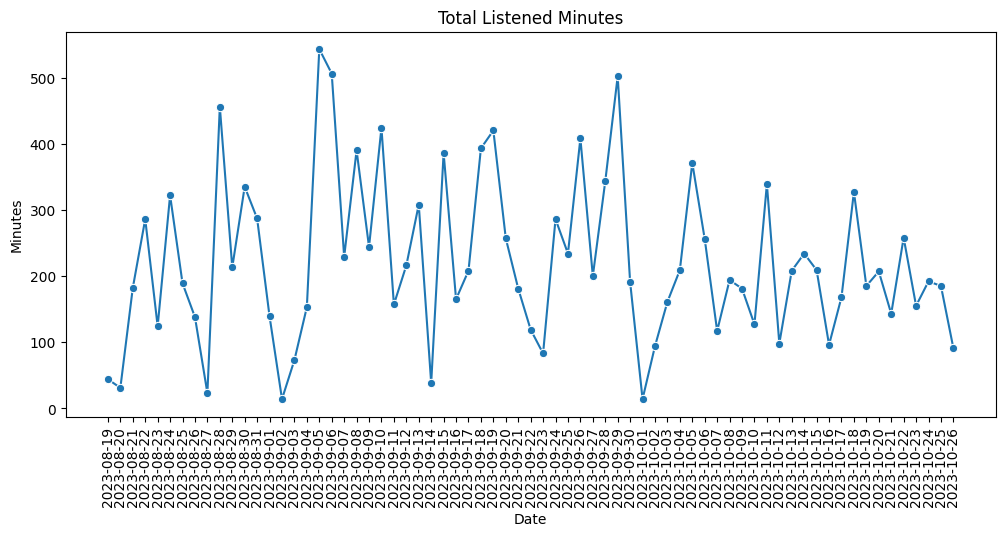

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title("Total Listened Minutes")
plt.xlabel("Date")
plt.ylabel("Minutes")
sns.lineplot(data=df["total_listened_seconds"] // 60, marker='o')
plt.xticks(rotation=90)
plt.gcf().set_size_inches(12, 5)
plt.show()

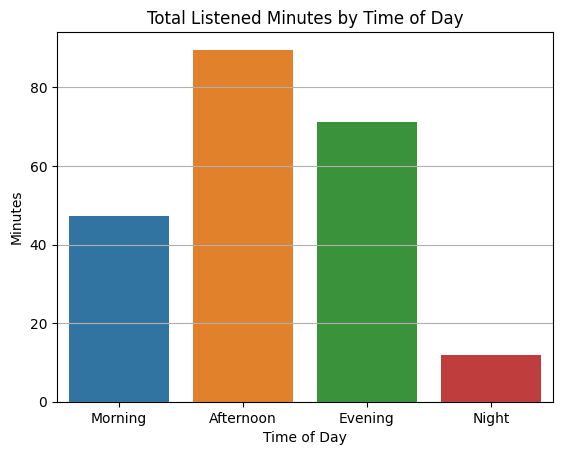

In [136]:
plt.title("Total Listened Minutes by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Minutes")
df["morning_listened_minutes"] = df["morning_listened_seconds"] // 60
df["afternoon_listened_minutes"] = df["afternoon_listened_seconds"] // 60
df["evening_listened_minutes"] = df["evening_listened_seconds"] // 60
df["night_listened_minutes"] = df["night_listened_seconds"] // 60
sns.barplot(data=df[["morning_listened_minutes", "afternoon_listened_minutes", "evening_listened_minutes", "night_listened_minutes"]], errorbar=None)
plt.xticks([0, 1, 2, 3], ["Morning", "Afternoon", "Evening", "Night"])
plt.grid(axis='y')
plt.show()

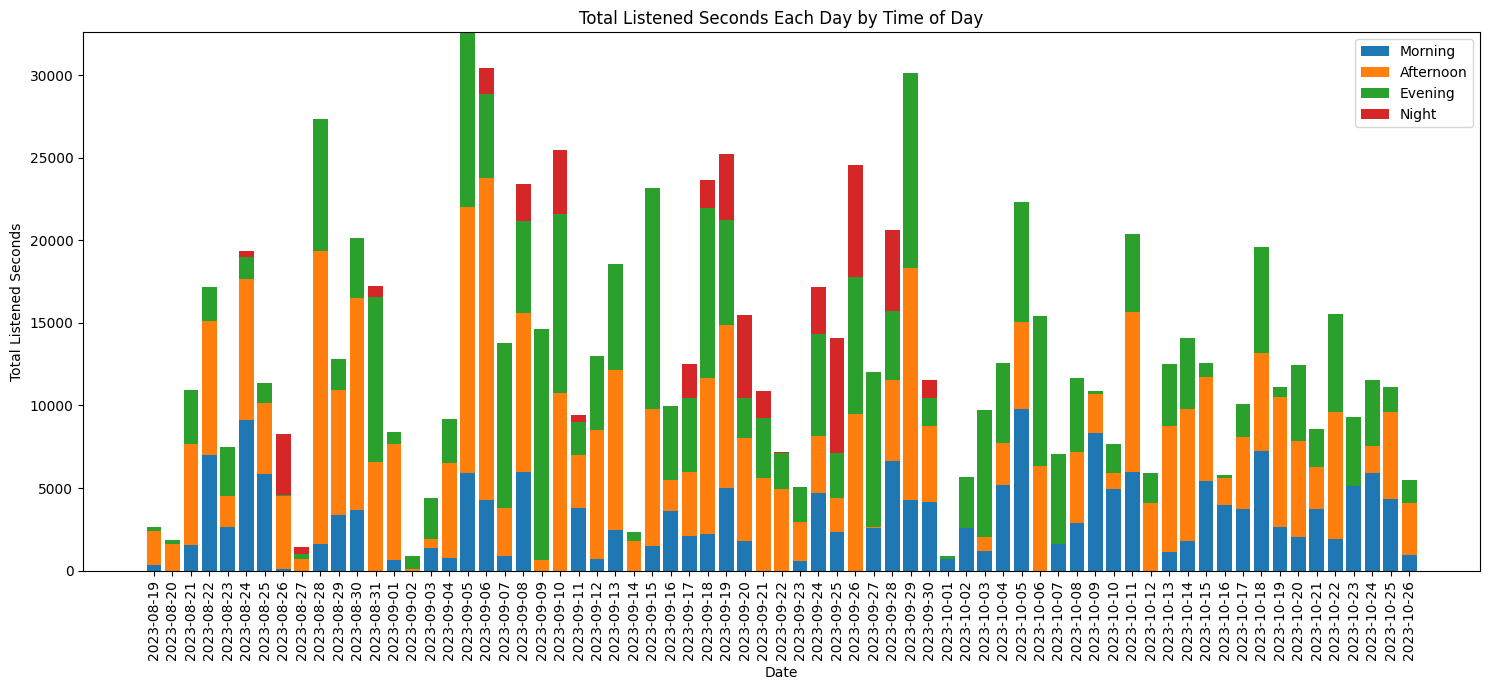

In [143]:
# Plotting stacked bar plot
plt.figure(figsize=(15, 7))
plt.bar(df.index, df['morning_listened_seconds'], label='Morning')
plt.bar(df.index, df['afternoon_listened_seconds'], bottom=df['morning_listened_seconds'], label='Afternoon')
plt.bar(df.index, df['evening_listened_seconds'], bottom=df['morning_listened_seconds'] + df['afternoon_listened_seconds'], label='Evening')
plt.bar(df.index, df['night_listened_seconds'], bottom=df['morning_listened_seconds'] + df['afternoon_listened_seconds'] + df['evening_listened_seconds'], label='Night')
plt.xticks(ticks=df.index, rotation=90)
plt.xlabel('Date')
plt.ylabel('Total Listened Seconds')
plt.title('Total Listened Seconds Each Day by Time of Day')
plt.legend()
plt.tight_layout()
plt.show()


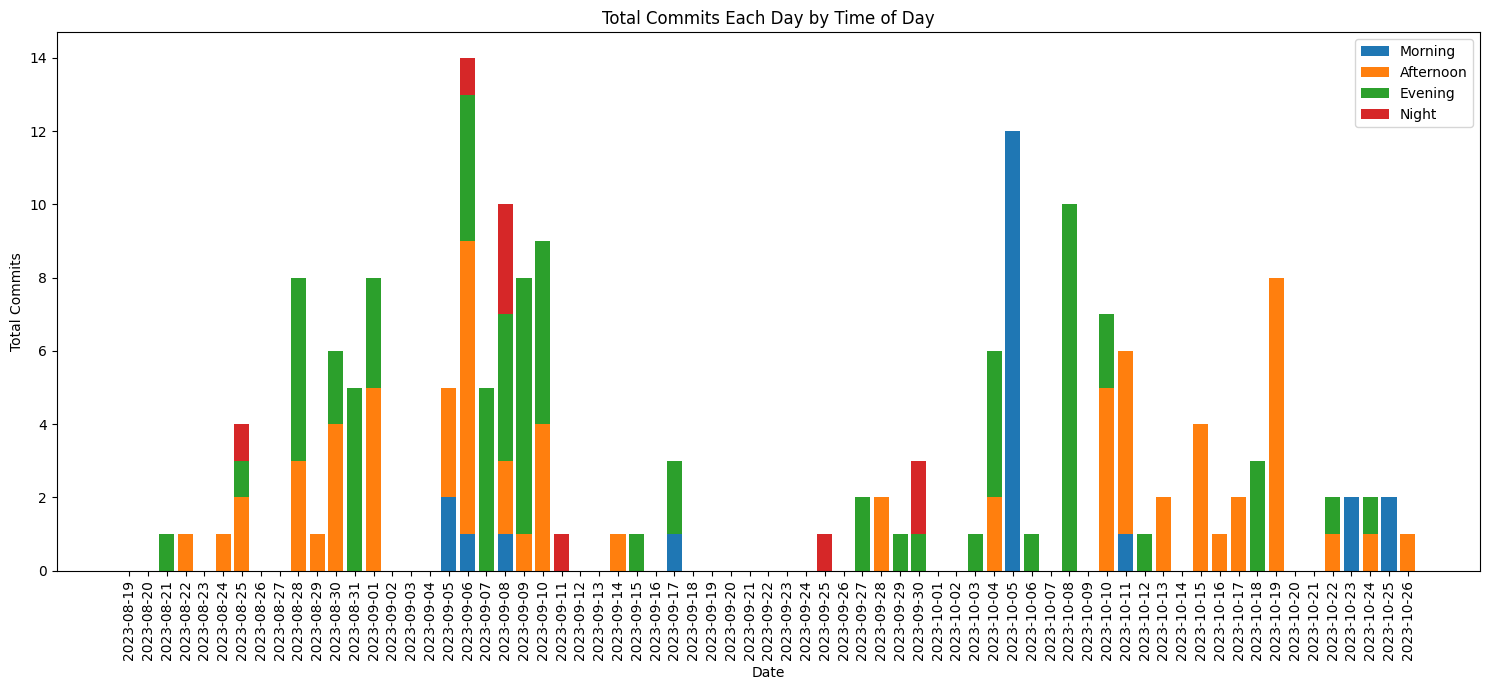

In [144]:
# Plotting stacked bar plot
plt.figure(figsize=(15, 7))
plt.bar(df.index, df['morning_commit_count'], label='Morning')
plt.bar(df.index, df['afternoon_commit_count'], bottom=df['morning_commit_count'], label='Afternoon')
plt.bar(df.index, df['evening_commit_count'], bottom=df['morning_commit_count'] + df['afternoon_commit_count'], label='Evening', )
plt.bar(df.index, df['night_commit_count'], bottom=df['morning_commit_count'] + df['afternoon_commit_count'] + df['evening_commit_count'], label='Night')
plt.xticks(ticks=df.index, rotation=90)
plt.xlabel('Date')
plt.ylabel('Total Commits')
plt.title('Total Commits Each Day by Time of Day')
plt.legend()
plt.tight_layout()
plt.show()


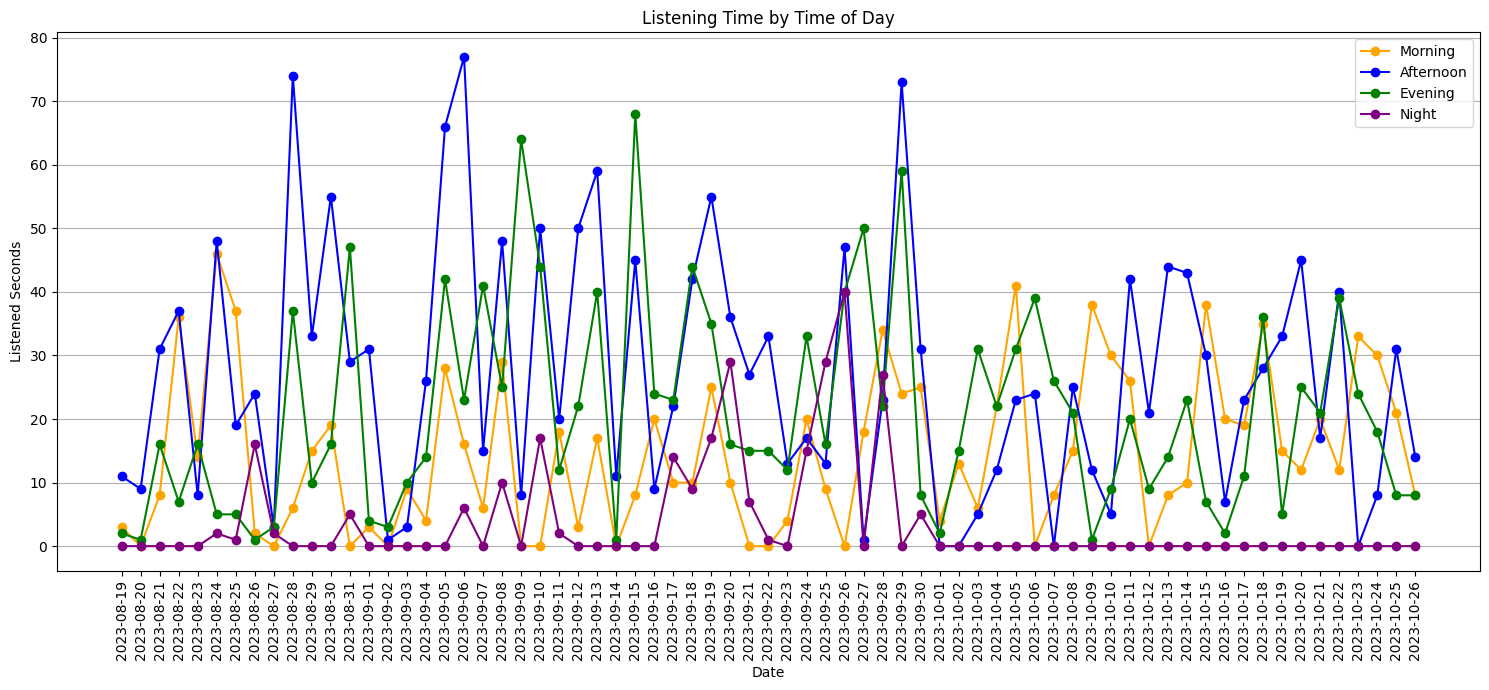

In [145]:
# Plotting a line chart with multiple lines for different times of the day
plt.figure(figsize=(15, 7))

# Plotting each time of day with a different line
plt.plot(df.index, df['morning_listened_count'], label='Morning', color='orange', marker='o')
plt.plot(df.index, df['afternoon_listened_count'], label='Afternoon', color='blue', marker='o')
plt.plot(df.index, df['evening_listened_count'], label='Evening', color='green', marker='o')
plt.plot(df.index, df['night_listened_count'], label='Night', color='purple', marker='o')

# Setting the labels and title
plt.xlabel('Date')
plt.ylabel('Listened Seconds')
plt.title('Listening Time by Time of Day')
plt.xticks(rotation=90, ticks=df.index)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


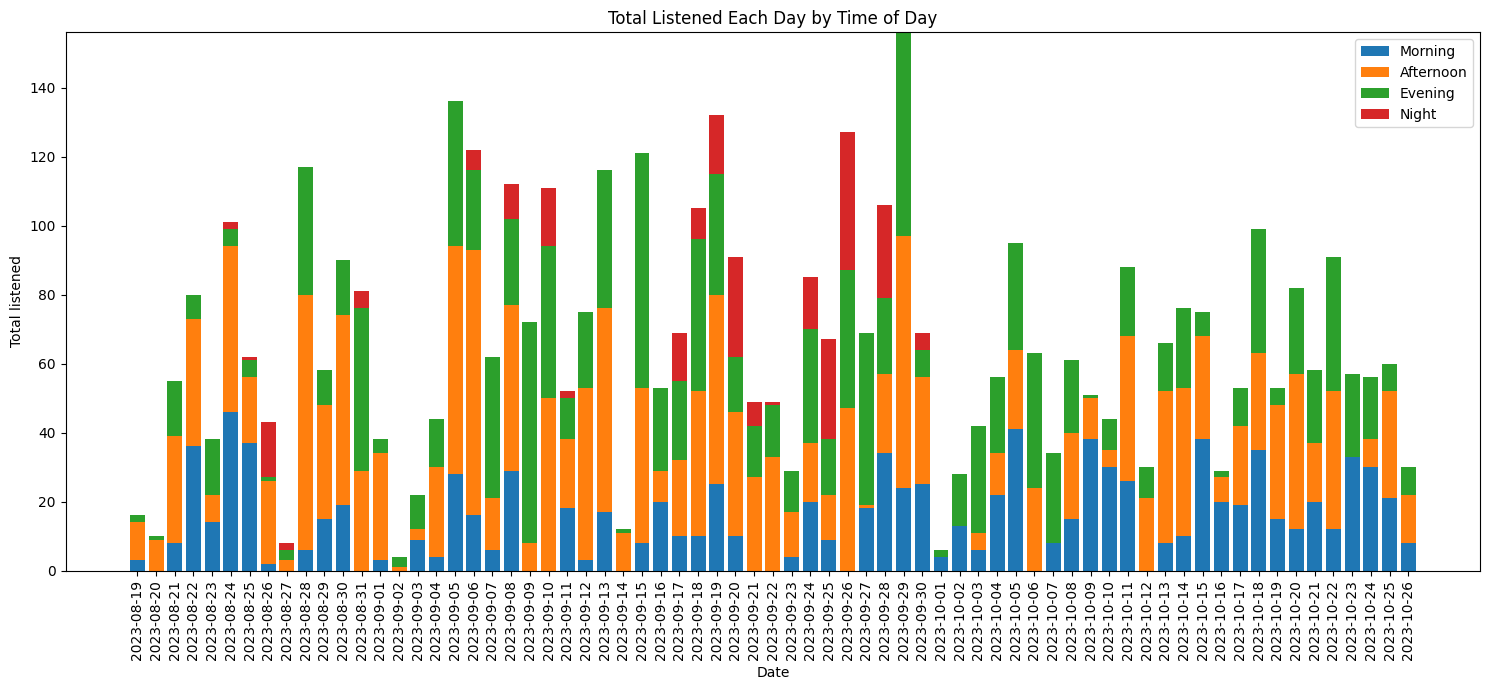

wake                          2023-09-05 12:00:00
sleep                         2023-09-06 05:00:00
awake_hours                                    17
total_commit_count                              5
total_listened_count                          136
total_listened_seconds                      32593
morning_listened_seconds                     5932
morning_listened_count                         28
morning_commit_count                            2
afternoon_listened_seconds                  16105
afternoon_listened_count                       66
afternoon_commit_count                          3
evening_listened_seconds                    10556
evening_listened_count                         42
evening_commit_count                            0
night_listened_seconds                          0
night_listened_count                            0
night_commit_count                              0
total_listened_minutes                        543
morning_listened_minutes                       98


In [164]:
# Plotting stacked bar plot
plt.figure(figsize=(15, 7))
plt.bar(df.index, df['morning_listened_count'], label='Morning')
plt.bar(df.index, df['afternoon_listened_count'], bottom=df['morning_listened_count'], label='Afternoon')
plt.bar(df.index, df['evening_listened_count'], bottom=df['morning_listened_count'] + df['afternoon_listened_count'], label='Evening')
plt.bar(df.index, df['night_listened_count'], bottom=df['morning_listened_count'] + df['afternoon_listened_count'] + df['evening_listened_count'], label='Night')
plt.xticks(ticks=df.index, rotation=90)
plt.xlabel('Date')
plt.ylabel('Total listened')
plt.title('Total Listened Each Day by Time of Day')
plt.legend()
plt.tight_layout()
plt.show()

# Print index = "2023-09-05"
print(df.loc["2023-09-05"])

## Machine Learning

- Does listening to more music and more time awake lead to more commits?
- Let's check for correlation values and see if we can train a regression model

Correlations of each feature with 'total_commit_count':
evening_commit_count          0.691992
afternoon_commit_count        0.684088
total_listened_minutes        0.440335
total_listened_seconds        0.440227
afternoon_listened_minutes    0.414247
afternoon_listened_seconds    0.414034
morning_commit_count          0.405140
total_listened_count          0.327875
afternoon_listened_count      0.311080
night_commit_count            0.300679
morning_listened_minutes      0.270479
morning_listened_seconds      0.270289
evening_listened_seconds      0.263537
evening_listened_minutes      0.263357
morning_listened_count        0.215791
evening_listened_count        0.193272
awake_hours                   0.018760
sleep                        -0.022080
wake                         -0.022201
night_listened_seconds       -0.045355
night_listened_minutes       -0.046027
night_listened_count         -0.068664
Name: total_commit_count, dtype: float64


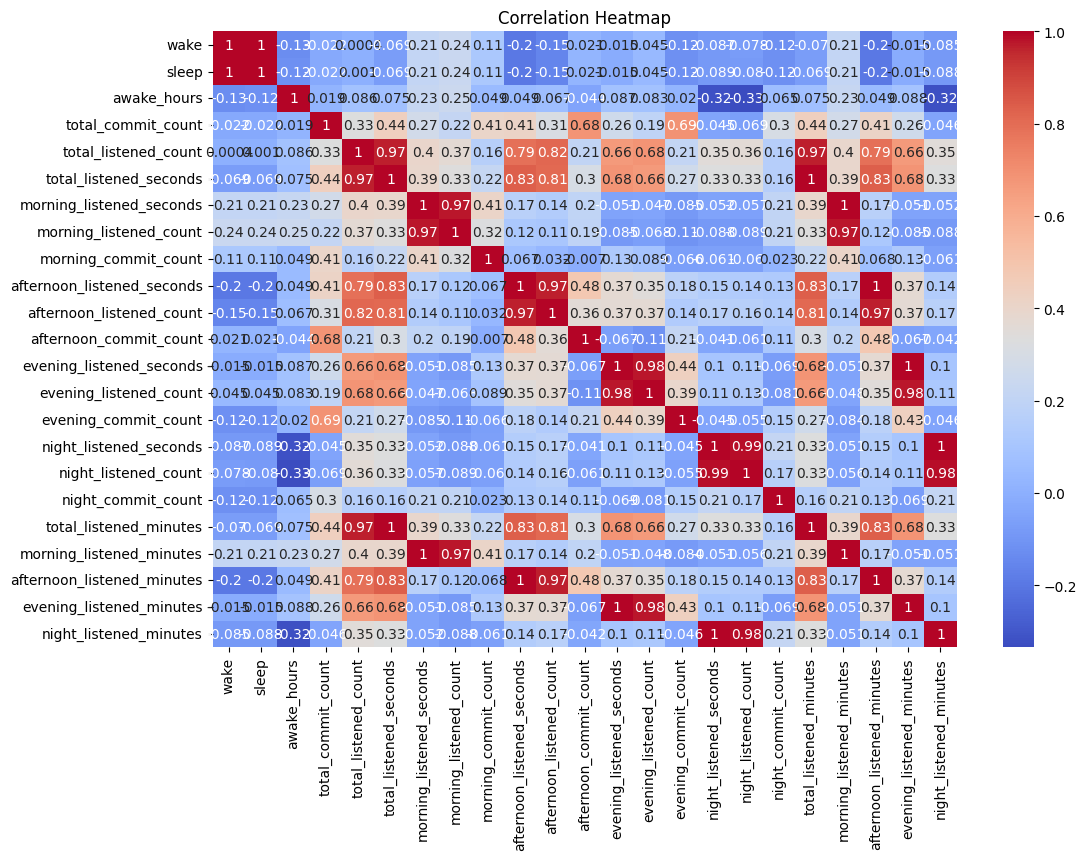

In [163]:
# Dependent variable
df_simplified = df[["total_commit_count", "total_listened_seconds", "total_listened_count", "awake_hours"]]
y = "total_commit_count"

# Independent variables
x = ["total_listened_seconds", "total_listened_count", "awake_hours"]

## Correlations of features with health
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")

# Calculate the correlation of each feature with y ('health_metrics')
correlations_commit_count = correlation_matrix['total_commit_count'].sort_values(ascending=False)
correlations_commit_count = correlations_commit_count.drop(labels=['total_commit_count'])

# Display the correlations
print("Correlations of each feature with 'total_commit_count':")
print(correlations_commit_count)

plt.show()




In [162]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Preparing the data
X = df[['awake_hours', 'total_listened_count', 'total_listened_seconds']]  # Features
y = df['total_commit_count']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Min square error: {mse}")
print(f"R2 score: {r2}")





Min square error: 14.19503694167859
R2 score: 0.36245938575412395


## Findings

- I found out that listening to music generally leads to higher commit count
- To be fair, committing does not directly equal since you can write code without commiting, but it is still an interesting find


## Limitations

- The sample size was very small, with 69 data points. Next time I would like to increase this size and also increase my commit rate to get even more interesting values. As for future plans, I could not bring it out for this project, but I plan on tracking my [typing speed]() so I might make a similar project to this one. Thank you for reading all the way through!